# Tutorial 5c - Optimization Case Study

### August 2024

This tutorial demonstrates how Optiland can be used to design an F/5 Cooke triplet starting from three (nearly) parallel plates.

In [1]:
import numpy as np

from optiland import analysis, optic, optimization

1. Definition of initial system

We start with a system that consists of 3 (nearly) parallel plates, in which all surface have an absolute radius of curvature of 1000 mm. The center element uses glass type F2, while the first and last lens use SK16.

We specify a maximum field of 20 degrees and an entrance pupil diameter of 10 mm. We will later specify a target focal length of 50 mm, which implies an F-number of 5.0 = 50 mm / 10 mm. We'll place the stop on the back side of the center lens.

In [2]:
class Triplet(optic.Optic):
    def __init__(self):
        super().__init__()

        # Define surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(index=1, radius=1000, thickness=4, material="SK16")
        self.add_surface(index=2, radius=-1000, thickness=5)
        self.add_surface(index=3, radius=-1000, thickness=4, material=("F2", "schott"))
        self.add_surface(index=4, radius=1000, thickness=5, is_stop=True)
        self.add_surface(index=5, radius=1000, thickness=4, material="SK16")
        self.add_surface(index=6, radius=-1000, thickness=50)
        self.add_surface(index=7)

        # Define aperture
        self.set_aperture(aperture_type="EPD", value=10.0)

        # Define fields
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=14)
        self.add_field(y=20)

        # Define wavelengths
        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

Let's view the starting point of the lens:

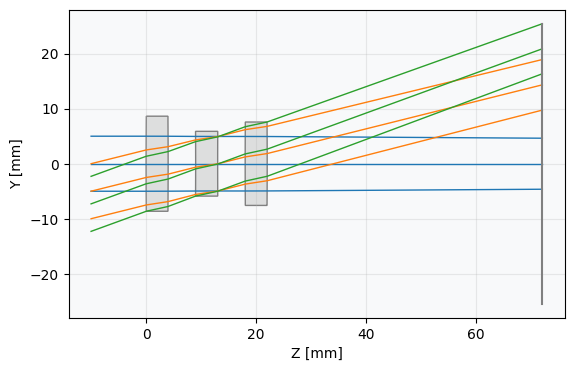

In [3]:
lens = Triplet()
fig = lens.draw()

2. Initial Optimization Step

While technically not required, we will identify a lens starting point that satisfies the required focal length and minimizes the seidel aberrations.

We first specify pickups on the surfaces to enforce symmetry in the design. The first and last lens surfaces should be equal and opposite. Similarly, the second and fifth, as well as third and fourth, should be equal and opposite.

We define this as follows, using a "scale" factor of -1 and an offset of 0. The radius of curvature is defined as $R_{new} = R * scale + offset$, where $R$ is the radius of curvature of the reference surface.

In [4]:
lens.pickups.add(
    source_surface_idx=1,
    attr_type="radius",
    target_surface_idx=6,
    scale=-1,
    offset=0,
)
lens.pickups.add(
    source_surface_idx=2,
    attr_type="radius",
    target_surface_idx=5,
    scale=-1,
    offset=0,
)
lens.pickups.add(
    source_surface_idx=3,
    attr_type="radius",
    target_surface_idx=4,
    scale=-1,
    offset=0,
)

Let's define the optimization problem. We first define the focal length and Seidel aberration operands:

In [5]:
problem = optimization.OptimizationProblem()

# Add requirement for focal length
problem.add_operand(operand_type="f2", target=50, weight=1, input_data={"optic": lens})

# Add requirements for Seidel aberrations (1 to 5)
for i in range(1, 6):
    problem.add_operand(
        operand_type="seidel",
        target=0,
        weight=10,
        input_data={"optic": lens, "seidel_number": i},
    )

Let's define the variables, which are the first 3 surface radii. Recall that the last 3 radii are picked up to these radii, so they do not need to also be specified as variables.

Finally, we view the optimization problem info.

In [6]:
problem.add_variable(lens, "radius", surface_number=1, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=2, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=3, min_val=-1000, max_val=1000)

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                 573580 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │ 807.351 │ 757.351 │            100 │
│  1 │ seidel         │        0 │              │              │       10 │  -0     │  -0     │              0 │
│  2 │ seidel         │        0 │              │              │       10 │   0     │   0     │              0 │
│  3 │ seidel         │        0 │              │             

We then perform optimization. Here, we use the least squares optimizer in Optiland, which simply wraps the implementation in scipy.optimize.least_squares.

In [7]:
optimizer = optimization.LeastSquares(problem)
res = optimizer.optimize(tol=1e-3, method_choice="trf")  # Trust Region Reflective (trf) method supports bounds

Let's view the optimization result. We see that there is a >99.99% improvement in the merit function.

In [8]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.305589 │           99.9999 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  50.01  │   0.01  │           0.03 │
│  1 │ seidel         │        0 │              │              │       10 │  -0.018 │  -0.018 │          10.63 │
│  2 │ seidel         │        0 │              │              │       10 │  -0.003 │  -0.003 │           0.26 │
│  3 │ seidel         │        0 │              │             

Before viewing, we call "image_solve" to move the image plane to the paraxial image location.

In [9]:
lens.image_solve()

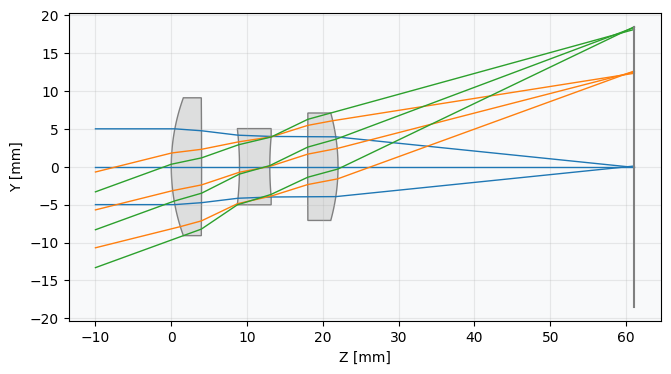

In [10]:
fig = lens.draw()

3. Second Optimization Step - Remove Symmetry Constraint

In the second step, we remove the requirement that the lens is symmetric. We first clear all pickups.

In [11]:
lens.pickups.clear()

Now that we have a starting design, we will no longer consider the Seidel aberrations. Instead, we will optimize for a minimal RMS spot size for all fields and wavelengths as follows:

In [12]:
# Clear all operands
problem.clear_operands()

# focal length requirement
problem.add_operand(operand_type="f2", target=50, weight=1, input_data={"optic": lens})

# RMS spot size requirement at (0, 0) field
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "wavelength": "all",
    "num_rays": 5,
}
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=10,
    input_data=input_data,
)

# RMS spot size requirement at (0, 0.7) field
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0.7,
    "wavelength": "all",
    "num_rays": 5,
}
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=10,
    input_data=input_data,
)

# RMS spot size requirement at (0, 1.0) field
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 1.0,
    "wavelength": "all",
    "num_rays": 5,
}
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=10,
    input_data=input_data,
)

We add the last 3 radii as variables, as well as the thickness to the image plane.

In [13]:
problem.add_variable(lens, "radius", surface_number=4, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=5, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=6, min_val=-1000, max_val=1000)

problem.add_variable(lens, "thickness", surface_number=6, min_val=0, max_val=1000)

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                4.21387 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  50.01  │   0.01  │           0    │
│  1 │ rms spot size  │        0 │              │              │       10 │   0.063 │   0.063 │           9.49 │
│  2 │ rms spot size  │        0 │              │              │       10 │   0.116 │   0.116 │          31.8  │
│  3 │ rms spot size  │        0 │              │             

Let's optimize the system, view the result and plot the lens. In this iteration, we use the generic optimizer in Optiland, which wraps scipy.optimize.minimmize.

In [14]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

In [15]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.200164 │           95.2499 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  50.009 │   0.009 │           0.04 │
│  1 │ rms spot size  │        0 │              │              │       10 │   0.018 │   0.018 │          16.38 │
│  2 │ rms spot size  │        0 │              │              │       10 │   0.03  │   0.03  │          45.81 │
│  3 │ rms spot size  │        0 │              │             

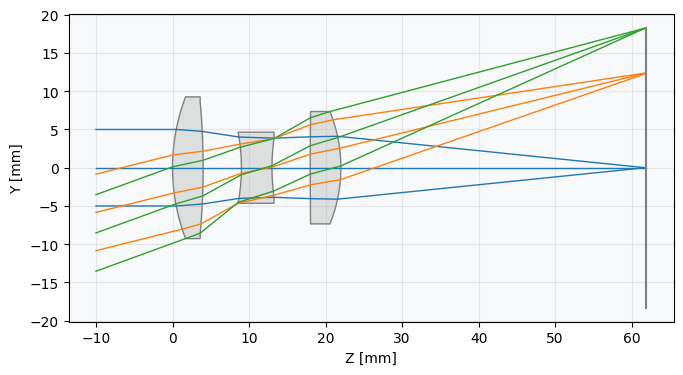

In [16]:
fig = lens.draw()

4. Final optimization - Fine Tuning

As a last step, we will let the thicknesses between the lenses vary and re-optimize. Allowing the lens thicknesses to vary is generally unnecessary, as it offers very little corrective power.

In [17]:
problem.add_variable(lens, "thickness", surface_number=2, min_val=1, max_val=10)
problem.add_variable(lens, "thickness", surface_number=4, min_val=1, max_val=10)

In [18]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.200164 │           95.2499 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  50.009 │   0.009 │           0.04 │
│  1 │ rms spot size  │        0 │              │              │       10 │   0.018 │   0.018 │          16.38 │
│  2 │ rms spot size  │        0 │              │              │       10 │   0.03  │   0.03  │          45.81 │
│  3 │ rms spot size  │        0 │              │             

Let's optimize the system one last time with all variables to fine tune the system.

In [19]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

In [20]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.110757 │           97.3716 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │  50.002 │   0.002 │           0    │
│  1 │ rms spot size  │        0 │              │              │       10 │   0.012 │   0.012 │          13.16 │
│  2 │ rms spot size  │        0 │              │              │       10 │   0.022 │   0.022 │          41.82 │
│  3 │ rms spot size  │        0 │              │             

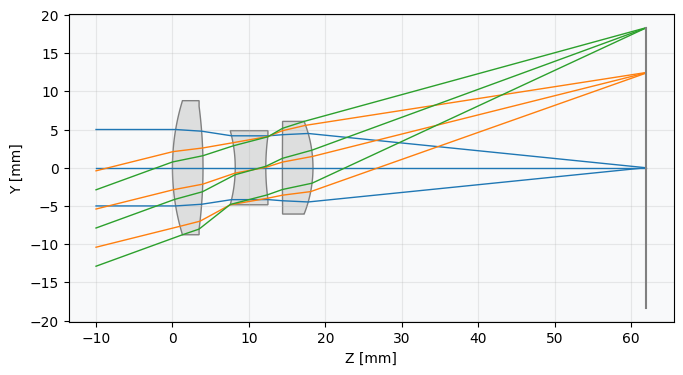

In [21]:
fig = lens.draw()

We view the spot diagram to see the final performance of our system.

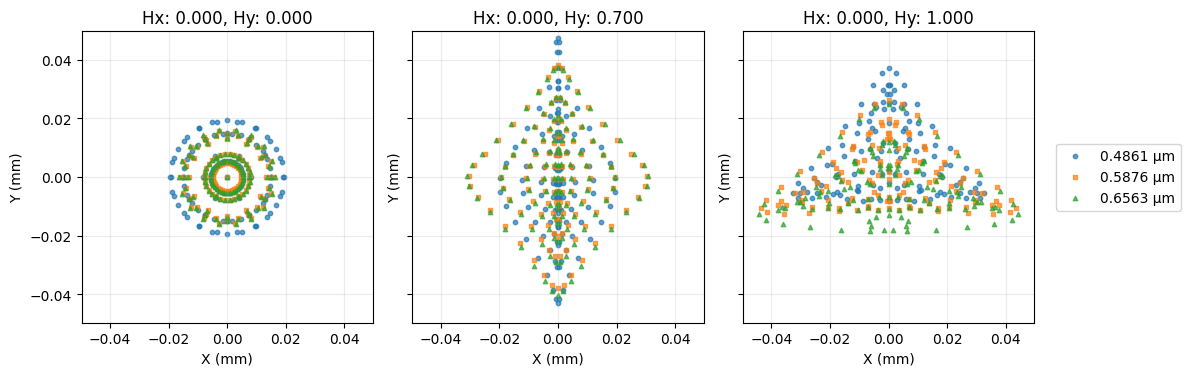

In [22]:
spot = analysis.SpotDiagram(lens)
spot.view()

And we print the RMS spot radii for each wavelength and field.

In [23]:
print("RMS Spot Radius:")

fields = lens.fields.get_field_coords()
wavelengths = lens.wavelengths.get_wavelengths()

rms_spot_radius = spot.rms_spot_radius()
for i, field in enumerate(fields):
    for j, wavelength in enumerate(wavelengths):
        print(
            f"\tField {field}, Wavelength {wavelength:.3f} µm, "
            f"Radius: {rms_spot_radius[i][j]:.5f} mm",
        )

RMS Spot Radius:
	Field (0.0, 0.0), Wavelength 0.486 µm, Radius: 0.01444 mm
	Field (0.0, 0.0), Wavelength 0.588 µm, Radius: 0.01076 mm
	Field (0.0, 0.0), Wavelength 0.656 µm, Radius: 0.01108 mm
	Field (0.0, 0.7), Wavelength 0.486 µm, Radius: 0.02149 mm
	Field (0.0, 0.7), Wavelength 0.588 µm, Radius: 0.02054 mm
	Field (0.0, 0.7), Wavelength 0.656 µm, Radius: 0.02113 mm
	Field (0.0, 1.0), Wavelength 0.486 µm, Radius: 0.02128 mm
	Field (0.0, 1.0), Wavelength 0.588 µm, Radius: 0.02242 mm
	Field (0.0, 1.0), Wavelength 0.656 µm, Radius: 0.02256 mm


Conclusions

- Starting from a simple system consisting of 3 (nearly) parallel plates, we designed a Cooke triplet. The triplet achieves an RMS spot size of ≈20 µm or less for all wavelengths and fields. We could have optimized the system to improve the performance further.
- We optimized for minimal RMS spot size, but we could have instead chosen to optimize the wavefront or other performance metrics. All operand possibilities can be seen in the operands module.
- This tutorial showed a typical example of optimizing an optical system from a simple starting point to a system with significantly improved performance. Lens optimization is complex and can be considered somewhat of an "art". With experience, the lens designer will learn how best to optimize lens systems to achieve target performance.